### The methodology in this notebook is a novel approach to transforming learned ResNet features into relation-aware graph embeddings to increase the classification accuracy of the maternal-fetal US images. The steps are as follows:
- Use the pre-trained ResNet152 model to extract the features of the US images. (Done in the feature_extraction_ResNet notebook and features are saved as npy files).
- Convert the extracted features into a graph structure where the nodes are the features and the edges are the relations between the features.
- The connections between the nodes are determined by the cosine similarity between the features. We avoid using Euclidean distance because features are high-dimensional (2048) and the cosine similarity is more robust to high-dimensional data. 
- Hence, curse of dimensionality is avoided.
- Nearest neighbors based on cosine similarity are used to determine the connections between the nodes.


### Cosine similarity formula to be used:
$$
\text{Cosine Similarity} = \frac{A \cdot B}{\|A\| \|B\|} = \frac{\sum_{i=1}^{n} A_i \cdot B_i}{\sqrt{\sum_{i=1}^{n} A_i^2} \sqrt{\sum_{i=1}^{n} B_i^2}}
$$

### Steps:
1. Load ResNet50 feature vectors.
2. Compute cosine similarity between all pairs of feature vectors.
3. Create a graph where each node is image's feature vector and connect the top 10 most cosine similar feature vectors.
4. Pass the graph through a GCN model to learn the embeddings.


### Load the features extracted from the ResNet152 model and the labels.

In [59]:
# Import saved ResNet features
import numpy as np
import pandas as pd


# Load Train Features
train_features_df = pd.read_csv('Custom_CNN_fusion_Stratified/train_features_mlp.csv')
train_labels = train_features_df['Label'].values
groups_train = train_features_df['Image'].str[:12].values  # ✅ Extract first 12 chars as patient ID
pseudo_labels_train = train_features_df['Pseudo_Label'].values
pseudo_probs_train = train_features_df['Pseudo_Prob'].values
train_features = train_features_df.drop(columns=['Label', 'Image', 'Pseudo_Label', 'Pseudo_Prob']).values 


# Load Test Features
test_features_df = pd.read_csv('Custom_CNN_fusion_Stratified/test_features_mlp.csv')
test_labels = test_features_df['Label'].values
groups_test = test_features_df['Image'].str[:12].values  # ✅ Extract first 12 chars as patient ID
pseudo_labels_test = test_features_df['Pseudo_Label'].values
pseudo_probs_test = test_features_df['Pseudo_Prob'].values
test_features = test_features_df.drop(columns=['Label', 'Image', 'Pseudo_Label', 'Pseudo_Prob']).values 


# Print the shape of the feature arrays
print('Train feature shape: ', train_features.shape)
print('Test feature shape: ', test_features.shape)


# Print the unique labels
print('Unique labels: ', np.unique(train_labels))
print('Number of unique labels: ', len(np.unique(train_labels)))

Train feature shape:  (9789, 256)
Test feature shape:  (2611, 256)
Unique labels:  [0 1 2 3 4 5]
Number of unique labels:  6


Train Class Distribution (%): [ 5.90458678 25.13024824  8.47890489 13.89314537 13.28021248 33.31290224], Number of Classes: [ 578 2460  830 1360 1300 3261]
Test Class Distribution (%): [ 5.09383378 24.20528533  8.04289544 13.71122175 12.48563769 36.46112601], Number of Classes: [133 632 210 358 326 952]


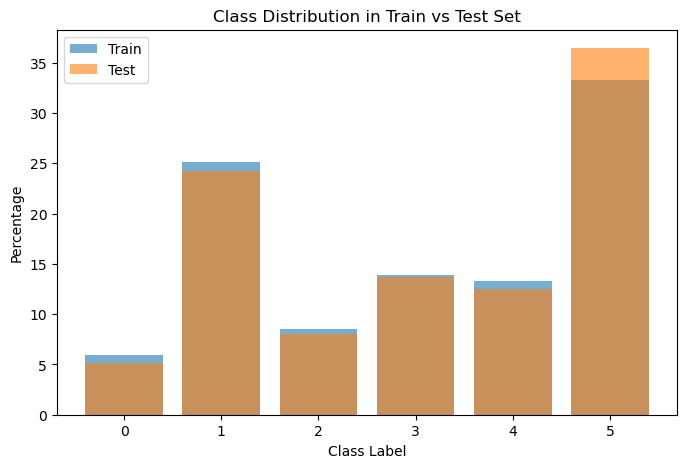

In [60]:
import numpy as np
import pandas as pd
import torch 

# Convert tensors back to numpy arrays if needed
train_labels_np = train_labels.numpy() if isinstance(train_labels, torch.Tensor) else train_labels
test_labels_np = test_labels.numpy() if isinstance(test_labels, torch.Tensor) else test_labels

# Count occurrences of each class
train_class_counts = np.bincount(train_labels_np)
test_class_counts = np.bincount(test_labels_np)

# Normalize to percentages
train_class_percent = train_class_counts / train_class_counts.sum() * 100
test_class_percent = test_class_counts / test_class_counts.sum() * 100

# Print class distributions and number of classes
print(f"Train Class Distribution (%): {train_class_percent}, Number of Classes: {train_class_counts}")
print(f"Test Class Distribution (%): {test_class_percent}, Number of Classes: {test_class_counts}")

# Plot the distributions
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(range(len(train_class_counts)), train_class_percent, alpha=0.6, label="Train")
plt.bar(range(len(test_class_counts)), test_class_percent, alpha=0.6, label="Test")
plt.xlabel("Class Label")
plt.ylabel("Percentage")
plt.legend()
plt.title("Class Distribution in Train vs Test Set")
plt.show()

In [57]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def feature_selection(train_features, test_features, method="variance", num_features=50):
    """
    Perform feature selection using either variance-based selection or PCA, and normalize the features.

    Args:
        train_features (np.array): Training feature matrix (samples x features).
        test_features (np.array): Test feature matrix (samples x features).
        method (str): Feature selection method, either "variance" or "pca".
        num_features (int): Number of features to retain. 
                            - If method="variance", selects the top `num_features` most variant features.
                            - If method="pca", reduces dimensionality to `num_features` principal components.

    Returns:
        train_features_selected (np.array): Transformed and normalized training features.
        test_features_selected (np.array): Transformed and normalized test features.
    """
    # Normalize features
    scaler = StandardScaler()
    train_features_normalized = scaler.fit_transform(train_features)
    test_features_normalized = scaler.transform(test_features)

    if method == "variance":
        # Compute variance of each feature across the normalized training set
        train_feature_variances = np.var(train_features_normalized, axis=0)
        
        # Get indices of the top `num_features` most variant features
        top_indices = np.argsort(train_feature_variances)[-num_features:]
        
        # Select these features for train and test sets
        train_features_selected = train_features_normalized[:, top_indices]
        test_features_selected = test_features_normalized[:, top_indices]  # Use same indices to maintain consistency
    
    elif method == "pca":
        # Perform PCA on normalized features
        pca = PCA(n_components=num_features)
        train_features_selected = pca.fit_transform(train_features_normalized)
        test_features_selected = pca.transform(test_features_normalized)

    else:
        raise ValueError("Invalid method. Choose either 'variance' or 'pca'.")

    return train_features_selected, test_features_selected


# Example Usage:
train_features_selected, test_features_selected = feature_selection(train_features, test_features, method="variance", num_features=50)
print("Shape after Feature Selection and Normalization - Train:", train_features_selected.shape)
print("Shape after Feature Selection and Normalization - Test:", test_features_selected.shape)


Shape after Feature Selection and Normalization - Train: (9789, 50)
Shape after Feature Selection and Normalization - Test: (2611, 50)


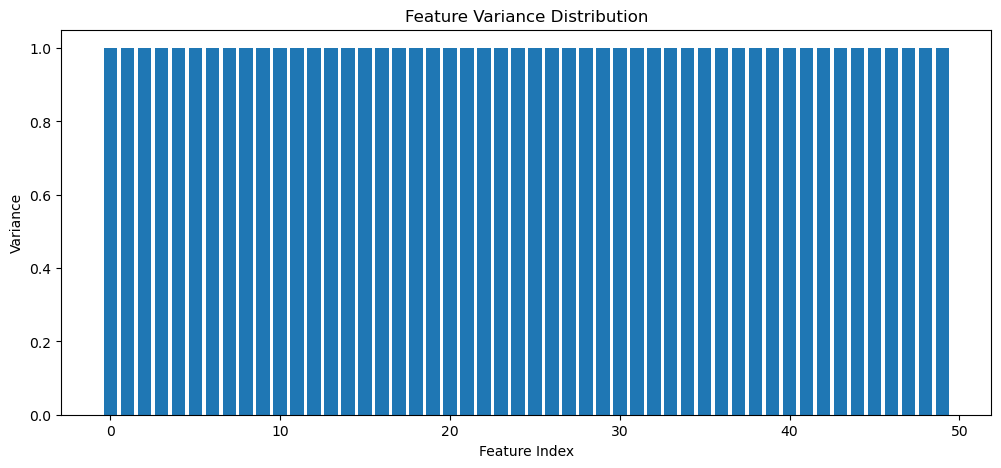

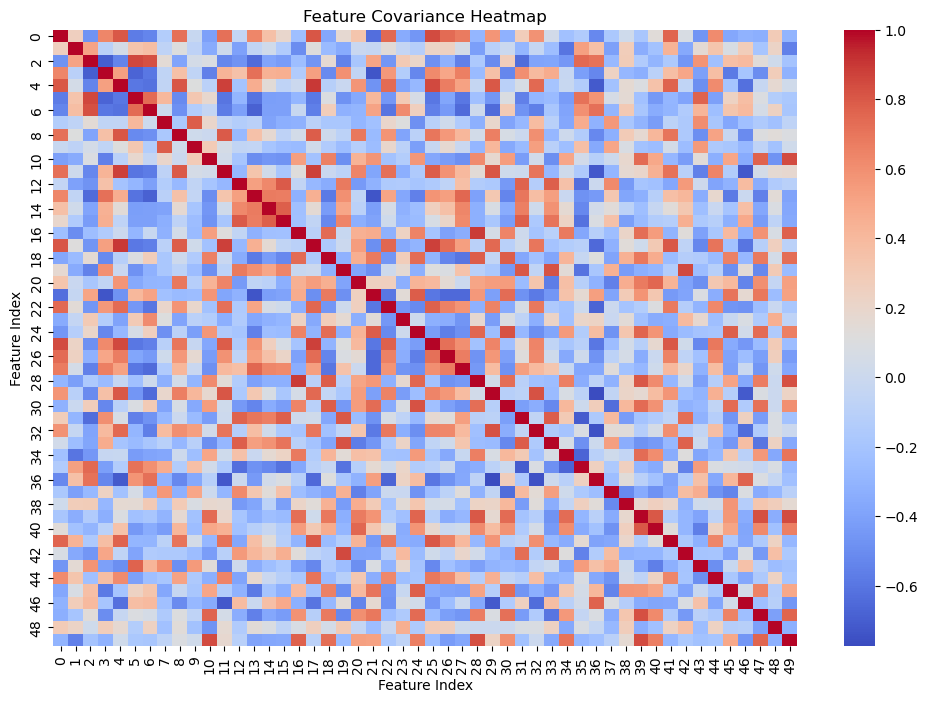

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns


# Plot Feature Variance
feature_variance = np.var(train_features_selected, axis=0)  # Compute variance for each feature
sorted_variance = np.sort(feature_variance)[::-1]  # Sort in descending order

plt.figure(figsize=(12, 5))
plt.bar(range(len(sorted_variance)), sorted_variance)
plt.xlabel("Feature Index")
plt.ylabel("Variance")
plt.title("Feature Variance Distribution")
plt.show()

# Compute & Plot Covariance Heatmap
cov_matrix = np.cov(train_features_selected, rowvar=False)  # Compute covariance

plt.figure(figsize=(12, 8))
sns.heatmap(cov_matrix, cmap="coolwarm", annot=False, fmt=".2f")
plt.title("Feature Covariance Heatmap")
plt.xlabel("Feature Index")
plt.ylabel("Feature Index")
plt.show()

### AWS Notebook Instance Requirements:

In [4]:
!pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.2.2+cu118.html

Looking in links: https://data.pyg.org/whl/torch-2.2.2+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 22.0 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.2/899.2 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.3 MB/s eta 0:00:00


### Construct a graph from the features extracted from the ResNet152 model. The graph is constructed by connecting the top mutual KNN based on cosine similarity.

In [49]:
import torch
import numpy as np
from torch_geometric.data import Data
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import pdist, squareform
from scipy.stats import entropy, spearmanr

def graph_data(features, labels, k=10, mutual_knn=False, similarity_method='cosine', threshold=None):
    num_nodes = features.shape[0]
    feature_tensor = torch.tensor(features, dtype=torch.float)
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    # Compute similarity matrix efficiently
    if similarity_method == 'cosine':
        similarity_matrix = cosine_similarity(features)
    
    elif similarity_method == 'pearson':
        similarity_matrix = np.corrcoef(features)
    
    elif similarity_method == 'spearman':
        spearman_corr, _ = spearmanr(features, axis=1)  # Fast vectorized computation
        similarity_matrix = spearman_corr

    elif similarity_method in ['chebyshev', 'manhattan', 'euclidean']:
        pairwise_distances = squareform(pdist(features, metric=similarity_method))  # Efficient
        similarity_matrix = np.exp(-pairwise_distances)  # Convert to similarity scores

    else:
        raise ValueError(f"Invalid similarity method: {similarity_method}")

    # Initialize adjacency matrix
    knn_graph = np.zeros_like(similarity_matrix)

    for i in range(num_nodes):
        # Step 1: Find the top-k most similar neighbors
        top_k_indices = np.argsort(similarity_matrix[i])[-k:]  # Select top-k neighbors

        # Step 2: Filter based on the threshold (only if threshold is not None)
        if threshold is not None:
            filtered_indices = [j for j in top_k_indices if similarity_matrix[i, j] >= threshold]
        else:
            filtered_indices = top_k_indices  # Keep all top-k neighbors

        if mutual_knn:
            # Ensure mutual nearest neighbor connections
            filtered_indices = [
                j for j in filtered_indices if i in np.argsort(similarity_matrix[j])[-k:]
            ]

        # Step 3: Create edges only if valid neighbors exist
        knn_graph[i, filtered_indices] = 1  # Set connections

    # Add self-loops
    np.fill_diagonal(knn_graph, 1)  # Set self-loops to 1
    
    # Convert adjacency matrix to edge index
    edge_index = np.array(np.nonzero(knn_graph))
    
    # Convert to PyTorch tensors
    edge_index = torch.tensor(edge_index, dtype=torch.long)

    # Create PyTorch Geometric graph data object
    data = Data(x=feature_tensor, edge_index=edge_index, y=labels_tensor)
    
    return data
# Example Usage
train_graph = graph_data(train_features_selected, train_labels, k=3, mutual_knn=False, similarity_method='cosine', threshold=None)
test_graph = graph_data(test_features_selected, test_labels, k=3, mutual_knn=False, similarity_method='cosine', threshold=None)

print(train_graph)
print(f"Nodes: {train_graph.num_nodes}, Edges: {train_graph.num_edges}")
print(f"Nodes: {test_graph.num_nodes}, Edges: {test_graph.num_edges}")

Data(x=[9789, 50], edge_index=[2, 29416], y=[9789])
Nodes: 9789, Edges: 29416
Nodes: 2611, Edges: 7861


In [64]:
import torch
import numpy as np
from torch_geometric.data import Data

def graph_data_separate_confidence(features, pseudo_labels, pseudo_probs, labels, max_neighbors=5, confidence_threshold=0.7, filter_test=False):
    """
    - Keeps all pseudo-labeled nodes in the **train graph**.
    - Filters out low-confidence pseudo-labeled nodes **only in the test graph** (if filter_test=True).
    """
    num_nodes = features.shape[0]
    feature_tensor = torch.tensor(features, dtype=torch.float)
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    # ✅ Identify high-confidence nodes
    if filter_test:
        high_confidence_indices = np.where(pseudo_probs >= confidence_threshold)[0]  # Filter only for test
    else:
        high_confidence_indices = np.arange(num_nodes)  # Keep all nodes for train

    high_confidence_features = features[high_confidence_indices]
    high_confidence_pseudo_labels = pseudo_labels[high_confidence_indices]
    high_confidence_labels = labels[high_confidence_indices]

    # Initialize adjacency matrix
    adjacency_matrix = np.zeros((len(high_confidence_indices), len(high_confidence_indices)))

    # ✅ Step 1: Connect high-confidence nodes based on pseudo-labels
    for idx, i in enumerate(high_confidence_indices):
        same_pseudo_label_indices = high_confidence_indices[high_confidence_pseudo_labels == high_confidence_pseudo_labels[idx]]

        # Exclude the current node
        same_pseudo_label_indices = same_pseudo_label_indices[same_pseudo_label_indices != i]

        # Limit to max_neighbors
        if len(same_pseudo_label_indices) > max_neighbors:
            same_pseudo_label_indices = np.random.choice(same_pseudo_label_indices, max_neighbors, replace=True)

        for j in same_pseudo_label_indices:
            adjacency_matrix[idx, np.where(high_confidence_indices == j)[0][0]] = 1  # Connect similar pseudo-labeled nodes

    # ✅ Step 2: Add self-loops
    np.fill_diagonal(adjacency_matrix, 1)

    # ✅ Step 3: Convert adjacency matrix to edge index
    edge_index = np.array(np.nonzero(adjacency_matrix))
    edge_index = torch.tensor(edge_index, dtype=torch.long)

    # ✅ Step 4: Ensure only high-confidence nodes are kept in the graph (for test)
    filtered_feature_tensor = torch.tensor(high_confidence_features, dtype=torch.float)
    filtered_labels_tensor = torch.tensor(high_confidence_labels, dtype=torch.long)

    # ✅ Create PyTorch Geometric Graph Data
    data = Data(x=filtered_feature_tensor, edge_index=edge_index, y=filtered_labels_tensor)
    
    return data

# ✅ Example Usage
train_graph = graph_data_separate_confidence(train_features, pseudo_labels_train, pseudo_probs_train, train_labels, max_neighbors=3, filter_test=False)
test_graph = graph_data_separate_confidence(test_features, pseudo_labels_test, pseudo_probs_test, test_labels, max_neighbors=3, filter_test=True)

print(train_graph)
print(f"Train Graph - Nodes: {train_graph.num_nodes}, Edges: {train_graph.num_edges}")
print(f"Test Graph - Nodes: {test_graph.num_nodes}, Edges: {test_graph.num_edges}")

Data(x=[9789, 256], edge_index=[2, 39141], y=[9789])
Train Graph - Nodes: 9789, Edges: 39141
Test Graph - Nodes: 2411, Edges: 9629


### We can also visualize the Graph structure, but it has thousands of nodes might want to visualize a subpart of it

/var/folders/gk/dsypcq4n5hg6hh5qdss0ly540000gn/T/ipykernel_1401/2852487311.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('jet', len(unique_labels))  # Generate color map


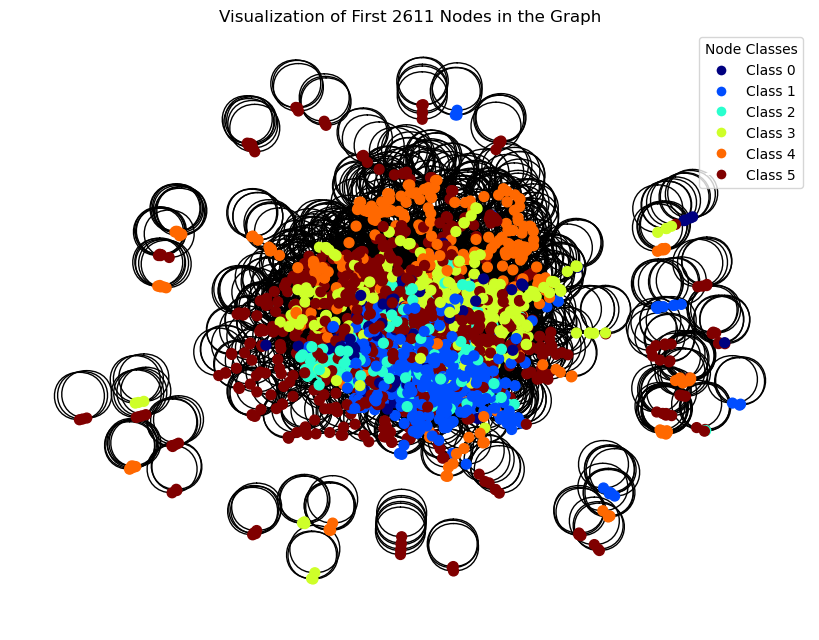

In [54]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import numpy as np

def visualize_subgraph(data):
    """
    Convert a PyTorch Geometric graph into a NetworkX graph and visualize a small subgraph.

    Args:
        data (torch_geometric.data.Data): Graph data.
       
    """
    
    num_nodes = data.num_nodes
    
    # Convert PyG graph to NetworkX format
    G = to_networkx(data, to_undirected=True)

    # Extract a subset of nodes
    sub_nodes = list(G.nodes)[:num_nodes]  # Select first `num_nodes`
    subgraph = G.subgraph(sub_nodes)

    # Assign colors based on class labels
    node_labels = np.array([data.y[i].item() for i in sub_nodes])  # Get labels of selected nodes
    unique_labels = np.unique(node_labels)  # Unique class labels

    # Create a color map for unique class labels
    color_map = plt.cm.get_cmap('jet', len(unique_labels))  # Generate color map
    label_color_mapping = {label: color_map(i / len(unique_labels)) for i, label in enumerate(unique_labels)}  # Map labels to colors
    node_colors = [label_color_mapping[label] for label in node_labels]  # Assign colors

    # Plot the graph
    plt.figure(figsize=(8, 6))
    nx.draw(subgraph, with_labels=False, node_size=50, node_color=node_colors)

    plt.title(f"Visualization of First {num_nodes} Nodes in the Graph")

    # Create a legend for the node colors
    legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=label_color_mapping[label], markersize=8, label=f"Class {label}") 
                      for label in unique_labels]
    plt.legend(handles=legend_patches, title="Node Classes", loc="upper right")

    plt.show()

# Call the function to visualize the graph (first 55 nodes)
visualize_subgraph(test_graph)

### Feature Space Augmentation to CNN extracted Features before passing to GCN:

In [12]:
import torch.nn.functional as F
import torch

def augment_features(graph_data, method="all", feature_dropout=0.2, edge_dropout=0.2, noise_std=0.05, scale_range=(0.9, 1.1), edge_swap_prob=0.1, training=True):
    """
    Applies different augmentation techniques to the graph data based on the selected method.

    Parameters:
    - graph_data (torch_geometric.data.Data): Input graph.
    - method (str): Type of augmentation to apply. Options:
        - "feature_dropout" : Randomly drops node features
        - "dropedge"        : Randomly removes edges
        - "noise"           : Adds Gaussian noise to features
        - "scale"           : Applies affine transformation (random scaling)
        - "edge_rewire"     : Randomly swaps edges
        - "all"             : Applies all augmentations in sequence
    - feature_dropout (float): Probability of feature dropout.
    - edge_dropout (float): Probability of edge removal.
    - noise_std (float): Standard deviation for Gaussian noise injection.
    - scale_range (tuple): Range for random feature scaling.
    - edge_swap_prob (float): Probability of swapping an edge.
    - training (bool): If False, no augmentation is applied.

    Returns:
    - torch_geometric.data.Data: Augmented graph.
    """

    if not training:
        return graph_data  # Return original graph during evaluation

    augmented_x = graph_data.x.clone()
    augmented_edge_index = graph_data.edge_index.clone()

    if method in ["feature_dropout", "all"]:
        augmented_x = F.dropout(augmented_x, p=feature_dropout, training=True)

    if method in ["noise", "all"]:
        noise = torch.randn_like(augmented_x) * noise_std
        augmented_x += noise

    if method in ["scale", "all"]:
        scale_factor = torch.empty_like(augmented_x).uniform_(scale_range[0], scale_range[1])
        augmented_x *= scale_factor

    if method in ["dropedge", "all"]:
        num_edges = augmented_edge_index.shape[1]
        keep_edges = torch.rand(num_edges) > edge_dropout
        augmented_edge_index = augmented_edge_index[:, keep_edges]

    if method in ["edge_rewire", "all"]:
        num_edges = augmented_edge_index.shape[1]
        num_swaps = int(edge_swap_prob * num_edges)
        if num_swaps > 0:
            perm = torch.randperm(num_edges)[:num_swaps]
            augmented_edge_index[:, perm] = augmented_edge_index[:, perm[torch.randperm(len(perm))]]  # Swap edges randomly

    return Data(
        x=augmented_x,
        edge_index=augmented_edge_index,
        y=graph_data.y
    )
    
# Apply only noise augmentation
aug_graph = augment_features(train_graph, method="feature_dropout")
    

### Import all Graph Convolution Neural Network models defined in utils folder.

In [62]:
import sys
import os

# Add the parent directory to the system path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from utils import GCNNClassifier, GCNN_Dot_Product, GCNN_Concat_Attention, GCNN_Prod_Res, GATClassifier, GraphSAGEClassifier


In [7]:
# Print the number of nodes and edges in the graph
print(f"Number of nodes in the training graph: {train_graph.num_nodes}")
print(f"Number of edges in the training graph: {train_graph.num_edges}")

Number of nodes in the training graph: 7129
Number of edges in the training graph: 71290


### Overview of the models:
 1. **GCNNClassifier**: A graph convolutional neural network designed for classification tasks on graph-structured data, leveraging the relationships between nodes to improve prediction accuracy.
 2. **GCNN_Dot_Product**: A variant of graph convolutional networks that utilizes dot product operations to combine node features, enhancing the model's ability to capture interactions between nodes.
 3. **GCNN_Concat_Attention**: This model employs attention mechanisms to weigh the importance of different node features, allowing for more nuanced representations in graph-based tasks.
 4. **GCNN_Prod_Res**: A graph convolutional network that integrates residual connections and product operations to facilitate deeper learning and improve performance on complex graph datasets.
 5. **GATClassifier**: A graph attention network classifier that uses attention mechanisms to dynamically focus on the most relevant nodes in the graph, improving classification performance.
 6. **GraphSAGEClassifier**: A scalable graph convolutional network that generates embeddings for nodes by sampling and aggregating features from their neighbors, making it suitable for large graphs.

### Choose which model to use for the task

In [67]:
# Choose the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Choose and Define the model
in_channels = train_graph.x.shape[1]  # (feature vector size)
hidden_channels = 256
num_classes = 6
model = GCNNClassifier(in_channels, hidden_channels, num_classes).to(device)

### Train the GCNN Model with the learned feature embeddings to predict US labels:
- Then we can compare the performance of the GCNN model with the ResNet-152 model.

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   1%|          | 1/100 [00:00<00:22,  4.39it/s]

Epoch 1, Train Loss: 1.8147, Val Loss: 1.3676, Train Acc: 0.14, Val Acc: 0.57


Training:   2%|▏         | 2/100 [00:00<00:23,  4.12it/s]

Epoch 2, Train Loss: 1.3691, Val Loss: 1.0171, Train Acc: 0.42, Val Acc: 0.91


Training:   3%|▎         | 3/100 [00:00<00:24,  3.88it/s]

Epoch 3, Train Loss: 1.0138, Val Loss: 0.7596, Train Acc: 0.79, Val Acc: 0.94


Training:   4%|▍         | 4/100 [00:01<00:24,  3.96it/s]

Epoch 4, Train Loss: 0.7412, Val Loss: 0.5837, Train Acc: 0.92, Val Acc: 0.94


Training:   5%|▌         | 5/100 [00:01<00:24,  3.88it/s]

Epoch 5, Train Loss: 0.5446, Val Loss: 0.4701, Train Acc: 0.96, Val Acc: 0.94


Training:   7%|▋         | 7/100 [00:01<00:21,  4.37it/s]

Epoch 6, Train Loss: 0.4073, Val Loss: 0.3996, Train Acc: 0.97, Val Acc: 0.94
Epoch 7, Train Loss: 0.3142, Val Loss: 0.3573, Train Acc: 0.98, Val Acc: 0.94


Training:   9%|▉         | 9/100 [00:02<00:17,  5.16it/s]

Epoch 8, Train Loss: 0.2501, Val Loss: 0.3328, Train Acc: 0.98, Val Acc: 0.94
Epoch 9, Train Loss: 0.2032, Val Loss: 0.3195, Train Acc: 0.98, Val Acc: 0.94


Training:  11%|█         | 11/100 [00:02<00:14,  6.19it/s]

Epoch 10, Train Loss: 0.1734, Val Loss: 0.3129, Train Acc: 0.98, Val Acc: 0.94
Epoch 11, Train Loss: 0.1492, Val Loss: 0.3105, Train Acc: 0.98, Val Acc: 0.94


Training:  13%|█▎        | 13/100 [00:02<00:13,  6.30it/s]

Epoch 12, Train Loss: 0.1324, Val Loss: 0.3105, Train Acc: 0.98, Val Acc: 0.94
Epoch 13, Train Loss: 0.1199, Val Loss: 0.3119, Train Acc: 0.98, Val Acc: 0.94


Training:  14%|█▍        | 14/100 [00:02<00:15,  5.73it/s]

Epoch 14, Train Loss: 0.1094, Val Loss: 0.3142, Train Acc: 0.98, Val Acc: 0.94


Training:  15%|█▌        | 15/100 [00:03<00:18,  4.64it/s]

Epoch 15, Train Loss: 0.1037, Val Loss: 0.3169, Train Acc: 0.98, Val Acc: 0.94


Training:  16%|█▌        | 16/100 [00:03<00:20,  4.06it/s]

Epoch 16, Train Loss: 0.0990, Val Loss: 0.3197, Train Acc: 0.98, Val Acc: 0.94


Training:  18%|█▊        | 18/100 [00:03<00:18,  4.45it/s]

Epoch 17, Train Loss: 0.0930, Val Loss: 0.3226, Train Acc: 0.98, Val Acc: 0.94
Epoch 18, Train Loss: 0.0903, Val Loss: 0.3255, Train Acc: 0.98, Val Acc: 0.94


Training:  20%|██        | 20/100 [00:04<00:15,  5.16it/s]

Epoch 19, Train Loss: 0.0881, Val Loss: 0.3282, Train Acc: 0.98, Val Acc: 0.94
Epoch 20, Train Loss: 0.0846, Val Loss: 0.3309, Train Acc: 0.98, Val Acc: 0.94


Training:  22%|██▏       | 22/100 [00:04<00:13,  5.94it/s]

Epoch 21, Train Loss: 0.0822, Val Loss: 0.3334, Train Acc: 0.98, Val Acc: 0.94
Epoch 22, Train Loss: 0.0815, Val Loss: 0.3357, Train Acc: 0.98, Val Acc: 0.94


Training:  24%|██▍       | 24/100 [00:04<00:11,  6.56it/s]

Epoch 23, Train Loss: 0.0774, Val Loss: 0.3380, Train Acc: 0.98, Val Acc: 0.94
Epoch 24, Train Loss: 0.0772, Val Loss: 0.3400, Train Acc: 0.98, Val Acc: 0.94


Training:  26%|██▌       | 26/100 [00:04<00:09,  7.48it/s]

Epoch 25, Train Loss: 0.0764, Val Loss: 0.3420, Train Acc: 0.98, Val Acc: 0.94
Epoch 26, Train Loss: 0.0751, Val Loss: 0.3438, Train Acc: 0.98, Val Acc: 0.94


Training:  28%|██▊       | 28/100 [00:05<00:08,  8.01it/s]

Epoch 27, Train Loss: 0.0756, Val Loss: 0.3454, Train Acc: 0.98, Val Acc: 0.94
Epoch 28, Train Loss: 0.0734, Val Loss: 0.3469, Train Acc: 0.98, Val Acc: 0.94


Training:  30%|███       | 30/100 [00:05<00:08,  8.41it/s]

Epoch 29, Train Loss: 0.0727, Val Loss: 0.3483, Train Acc: 0.98, Val Acc: 0.94
Epoch 30, Train Loss: 0.0738, Val Loss: 0.3495, Train Acc: 0.98, Val Acc: 0.94


Training:  32%|███▏      | 32/100 [00:05<00:07,  8.54it/s]

Epoch 31, Train Loss: 0.0732, Val Loss: 0.3507, Train Acc: 0.98, Val Acc: 0.94
Epoch 32, Train Loss: 0.0698, Val Loss: 0.3517, Train Acc: 0.98, Val Acc: 0.94


Training:  34%|███▍      | 34/100 [00:05<00:07,  8.28it/s]

Epoch 33, Train Loss: 0.0725, Val Loss: 0.3526, Train Acc: 0.98, Val Acc: 0.94
Epoch 34, Train Loss: 0.0721, Val Loss: 0.3534, Train Acc: 0.98, Val Acc: 0.94


Training:  36%|███▌      | 36/100 [00:06<00:08,  7.95it/s]

Epoch 35, Train Loss: 0.0703, Val Loss: 0.3541, Train Acc: 0.98, Val Acc: 0.94
Epoch 36, Train Loss: 0.0689, Val Loss: 0.3548, Train Acc: 0.98, Val Acc: 0.94


Training:  38%|███▊      | 38/100 [00:06<00:08,  7.68it/s]

Epoch 37, Train Loss: 0.0699, Val Loss: 0.3554, Train Acc: 0.98, Val Acc: 0.94
Epoch 38, Train Loss: 0.0692, Val Loss: 0.3559, Train Acc: 0.98, Val Acc: 0.94


Training:  40%|████      | 40/100 [00:06<00:08,  7.49it/s]

Epoch 39, Train Loss: 0.0687, Val Loss: 0.3564, Train Acc: 0.98, Val Acc: 0.94
Epoch 40, Train Loss: 0.0681, Val Loss: 0.3567, Train Acc: 0.98, Val Acc: 0.94


Training:  42%|████▏     | 42/100 [00:06<00:07,  7.77it/s]

Epoch 41, Train Loss: 0.0654, Val Loss: 0.3571, Train Acc: 0.98, Val Acc: 0.94
Epoch 42, Train Loss: 0.0703, Val Loss: 0.3573, Train Acc: 0.98, Val Acc: 0.94


Training:  44%|████▍     | 44/100 [00:07<00:06,  8.05it/s]

Epoch 43, Train Loss: 0.0669, Val Loss: 0.3575, Train Acc: 0.98, Val Acc: 0.94
Epoch 44, Train Loss: 0.0680, Val Loss: 0.3577, Train Acc: 0.98, Val Acc: 0.94


Training:  46%|████▌     | 46/100 [00:07<00:06,  8.55it/s]

Epoch 45, Train Loss: 0.0684, Val Loss: 0.3578, Train Acc: 0.98, Val Acc: 0.94
Epoch 46, Train Loss: 0.0672, Val Loss: 0.3578, Train Acc: 0.98, Val Acc: 0.94


Training:  48%|████▊     | 48/100 [00:07<00:06,  8.56it/s]

Epoch 47, Train Loss: 0.0657, Val Loss: 0.3579, Train Acc: 0.98, Val Acc: 0.94
Epoch 48, Train Loss: 0.0660, Val Loss: 0.3579, Train Acc: 0.98, Val Acc: 0.94


Training:  50%|█████     | 50/100 [00:07<00:05,  8.74it/s]

Epoch 49, Train Loss: 0.0657, Val Loss: 0.3579, Train Acc: 0.98, Val Acc: 0.94
Epoch 50, Train Loss: 0.0642, Val Loss: 0.3579, Train Acc: 0.98, Val Acc: 0.94


Training:  52%|█████▏    | 52/100 [00:08<00:05,  8.65it/s]

Epoch 51, Train Loss: 0.0666, Val Loss: 0.3578, Train Acc: 0.98, Val Acc: 0.94
Epoch 52, Train Loss: 0.0661, Val Loss: 0.3578, Train Acc: 0.98, Val Acc: 0.94


Training:  54%|█████▍    | 54/100 [00:08<00:05,  8.96it/s]

Epoch 53, Train Loss: 0.0670, Val Loss: 0.3578, Train Acc: 0.98, Val Acc: 0.94
Epoch 54, Train Loss: 0.0654, Val Loss: 0.3577, Train Acc: 0.98, Val Acc: 0.94


Training:  56%|█████▌    | 56/100 [00:08<00:04,  8.99it/s]

Epoch 55, Train Loss: 0.0663, Val Loss: 0.3577, Train Acc: 0.98, Val Acc: 0.94
Epoch 56, Train Loss: 0.0658, Val Loss: 0.3576, Train Acc: 0.98, Val Acc: 0.94


Training:  58%|█████▊    | 58/100 [00:08<00:04,  9.45it/s]

Epoch 57, Train Loss: 0.0658, Val Loss: 0.3576, Train Acc: 0.98, Val Acc: 0.94
Epoch 58, Train Loss: 0.0681, Val Loss: 0.3575, Train Acc: 0.98, Val Acc: 0.94


Training:  60%|██████    | 60/100 [00:08<00:04,  9.00it/s]

Epoch 59, Train Loss: 0.0676, Val Loss: 0.3575, Train Acc: 0.98, Val Acc: 0.94
Epoch 60, Train Loss: 0.0668, Val Loss: 0.3575, Train Acc: 0.98, Val Acc: 0.94


Training:  62%|██████▏   | 62/100 [00:09<00:04,  8.66it/s]

Epoch 61, Train Loss: 0.0647, Val Loss: 0.3574, Train Acc: 0.98, Val Acc: 0.94
Epoch 62, Train Loss: 0.0663, Val Loss: 0.3574, Train Acc: 0.98, Val Acc: 0.94


Training:  64%|██████▍   | 64/100 [00:09<00:04,  8.30it/s]

Epoch 63, Train Loss: 0.0673, Val Loss: 0.3574, Train Acc: 0.98, Val Acc: 0.94
Epoch 64, Train Loss: 0.0640, Val Loss: 0.3573, Train Acc: 0.98, Val Acc: 0.94


Training:  66%|██████▌   | 66/100 [00:09<00:04,  8.18it/s]

Epoch 65, Train Loss: 0.0643, Val Loss: 0.3573, Train Acc: 0.98, Val Acc: 0.94
Epoch 66, Train Loss: 0.0655, Val Loss: 0.3573, Train Acc: 0.98, Val Acc: 0.94


Training:  68%|██████▊   | 68/100 [00:09<00:04,  7.79it/s]

Epoch 67, Train Loss: 0.0667, Val Loss: 0.3573, Train Acc: 0.98, Val Acc: 0.94
Epoch 68, Train Loss: 0.0651, Val Loss: 0.3573, Train Acc: 0.98, Val Acc: 0.94


Training:  70%|███████   | 70/100 [00:10<00:03,  8.20it/s]

Epoch 69, Train Loss: 0.0666, Val Loss: 0.3572, Train Acc: 0.98, Val Acc: 0.94
Epoch 70, Train Loss: 0.0631, Val Loss: 0.3572, Train Acc: 0.98, Val Acc: 0.94


Training:  72%|███████▏  | 72/100 [00:10<00:03,  8.68it/s]

Epoch 71, Train Loss: 0.0646, Val Loss: 0.3571, Train Acc: 0.98, Val Acc: 0.94
Epoch 72, Train Loss: 0.0663, Val Loss: 0.3571, Train Acc: 0.98, Val Acc: 0.94


Training:  74%|███████▍  | 74/100 [00:10<00:03,  8.62it/s]

Epoch 73, Train Loss: 0.0681, Val Loss: 0.3570, Train Acc: 0.98, Val Acc: 0.94
Epoch 74, Train Loss: 0.0665, Val Loss: 0.3570, Train Acc: 0.98, Val Acc: 0.94


Training:  76%|███████▌  | 76/100 [00:10<00:03,  7.89it/s]

Epoch 75, Train Loss: 0.0657, Val Loss: 0.3569, Train Acc: 0.98, Val Acc: 0.94
Epoch 76, Train Loss: 0.0655, Val Loss: 0.3568, Train Acc: 0.98, Val Acc: 0.94


Training:  78%|███████▊  | 78/100 [00:11<00:02,  8.27it/s]

Epoch 77, Train Loss: 0.0671, Val Loss: 0.3568, Train Acc: 0.98, Val Acc: 0.94
Epoch 78, Train Loss: 0.0642, Val Loss: 0.3567, Train Acc: 0.98, Val Acc: 0.94


Training:  80%|████████  | 80/100 [00:11<00:02,  7.95it/s]

Epoch 79, Train Loss: 0.0635, Val Loss: 0.3567, Train Acc: 0.98, Val Acc: 0.94
Epoch 80, Train Loss: 0.0657, Val Loss: 0.3566, Train Acc: 0.98, Val Acc: 0.94


Training:  83%|████████▎ | 83/100 [00:11<00:01,  8.87it/s]

Epoch 81, Train Loss: 0.0659, Val Loss: 0.3566, Train Acc: 0.98, Val Acc: 0.94
Epoch 82, Train Loss: 0.0666, Val Loss: 0.3565, Train Acc: 0.98, Val Acc: 0.94
Epoch 83, Train Loss: 0.0654, Val Loss: 0.3565, Train Acc: 0.98, Val Acc: 0.94


Training:  85%|████████▌ | 85/100 [00:11<00:01,  8.95it/s]

Epoch 84, Train Loss: 0.0643, Val Loss: 0.3565, Train Acc: 0.98, Val Acc: 0.94
Epoch 85, Train Loss: 0.0669, Val Loss: 0.3565, Train Acc: 0.98, Val Acc: 0.94


Training:  87%|████████▋ | 87/100 [00:12<00:01,  8.99it/s]

Epoch 86, Train Loss: 0.0636, Val Loss: 0.3565, Train Acc: 0.98, Val Acc: 0.94
Epoch 87, Train Loss: 0.0645, Val Loss: 0.3565, Train Acc: 0.98, Val Acc: 0.94


Training:  89%|████████▉ | 89/100 [00:12<00:01,  7.89it/s]

Epoch 88, Train Loss: 0.0650, Val Loss: 0.3566, Train Acc: 0.98, Val Acc: 0.94
Epoch 89, Train Loss: 0.0655, Val Loss: 0.3567, Train Acc: 0.98, Val Acc: 0.94


Training:  91%|█████████ | 91/100 [00:12<00:01,  8.12it/s]

Epoch 90, Train Loss: 0.0641, Val Loss: 0.3567, Train Acc: 0.98, Val Acc: 0.94
Epoch 91, Train Loss: 0.0654, Val Loss: 0.3568, Train Acc: 0.98, Val Acc: 0.94


Training:  93%|█████████▎| 93/100 [00:12<00:00,  8.76it/s]

Epoch 92, Train Loss: 0.0662, Val Loss: 0.3569, Train Acc: 0.98, Val Acc: 0.94
Epoch 93, Train Loss: 0.0650, Val Loss: 0.3570, Train Acc: 0.98, Val Acc: 0.94


Training:  95%|█████████▌| 95/100 [00:13<00:00,  7.56it/s]

Epoch 94, Train Loss: 0.0646, Val Loss: 0.3571, Train Acc: 0.98, Val Acc: 0.94
Epoch 95, Train Loss: 0.0640, Val Loss: 0.3571, Train Acc: 0.98, Val Acc: 0.94


Training:  96%|█████████▌| 96/100 [00:13<00:00,  6.95it/s]

Epoch 96, Train Loss: 0.0636, Val Loss: 0.3572, Train Acc: 0.98, Val Acc: 0.94


Training:  98%|█████████▊| 98/100 [00:14<00:00,  4.29it/s]

Epoch 97, Train Loss: 0.0637, Val Loss: 0.3572, Train Acc: 0.98, Val Acc: 0.94
Epoch 98, Train Loss: 0.0660, Val Loss: 0.3573, Train Acc: 0.98, Val Acc: 0.94


Training: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]

Epoch 99, Train Loss: 0.0664, Val Loss: 0.3573, Train Acc: 0.98, Val Acc: 0.94
Epoch 100, Train Loss: 0.0645, Val Loss: 0.3573, Train Acc: 0.98, Val Acc: 0.94


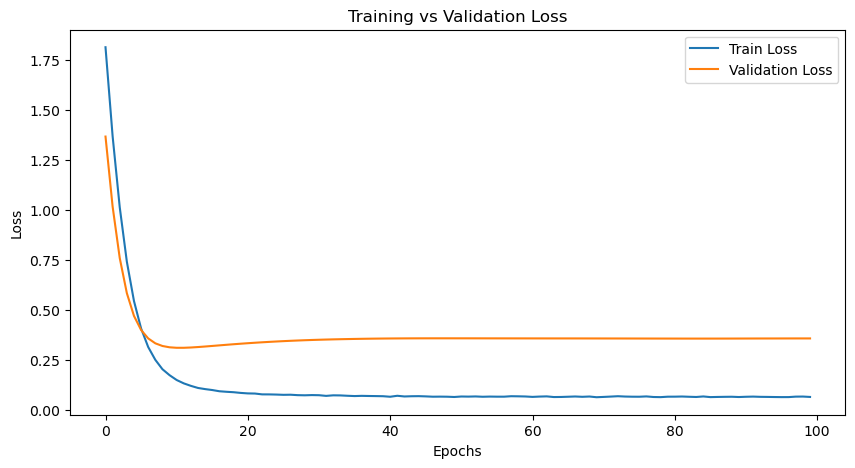

In [68]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight


# Get unique classes
unique_classes = np.unique(train_labels)
# Compute class weights
class_weights = compute_class_weight(class_weight="balanced", classes=unique_classes, y=train_labels)
# Convert to PyTorch tensor
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)


# Define loss function and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-2)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
# ADD LEARNING RATE SCHEDULER
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)  # Reduce LR every 50 epochs


# Early stopping parameters (based on validation accuracy)
best_val_acc = 0.0
patience = 100
counter = 0

# Lists to store losses
train_losses = []
val_losses = []

# Training loop
num_epochs = 100  # Set high, but will stop early if necessary

for epoch in tqdm(range(num_epochs), desc="Training", total=num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    out = model(train_graph.x.to(device), train_graph.edge_index.to(device))
    train_loss = criterion(out, train_graph.y.to(device))
    train_loss.backward()
    optimizer.step()
    scheduler.step() 
    
    # Compute training accuracy
    pred_train = out.argmax(dim=1)
    train_acc = (pred_train == train_graph.y.to(device)).sum().item() / train_graph.y.size(0)

    # Validation step
    model.eval()
    with torch.no_grad():
        val_out = model(test_graph.x.to(device), test_graph.edge_index.to(device))
        val_loss = criterion(val_out, test_graph.y.to(device))

        # Convert logits to probabilities
        val_probs = torch.softmax(val_out, dim=1)  
        pred_val = val_probs.argmax(dim=1)  # Get class predictions
        # Compute validation accuracy
        val_acc = (pred_val == test_graph.y.to(device)).sum().item() / test_graph.y.size(0)

    # Store losses
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())


    print(f"Epoch {epoch+1}, Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Train Acc: {train_acc:.2f}, Val Acc: {val_acc:.2f}")

    # Early Stopping Logic (Based on Validation Accuracy)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        counter = 0
        torch.save(model.state_dict(), "best_gcnn.pth")  # Save best model
    else:
        counter += 1
        if counter >= patience:
            print(f"Stopping early at epoch {epoch+1}. Best Val Acc: {best_val_acc:.2f}")
            break

# Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

In [70]:
from sklearn.metrics import classification_report

# Load the best model
model.load_state_dict(torch.load("best_gcnn.pth"))
model.eval()

# Get predictions and true labels
with torch.no_grad():
    out = model(test_graph.x.to(device), test_graph.edge_index.to(device))
    probs = torch.softmax(out, dim=1)  # Convert logits to probabilities
    pred = probs.argmax(dim=1).cpu().numpy()  # Get class predictions
    true_labels = test_graph.y.cpu().numpy()

# Classification Report
print(classification_report(true_labels, pred, digits=4))

              precision    recall  f1-score   support

           0     0.7328    0.8173    0.7727       104
           1     0.9901    0.9901    0.9901       607
           2     0.8182    0.9396    0.8747       182
           3     0.8793    0.9533    0.9148       321
           4     1.0000    0.9969    0.9985       325
           5     0.9641    0.8922    0.9267       872

    accuracy                         0.9394      2411
   macro avg     0.8974    0.9316    0.9129      2411
weighted avg     0.9432    0.9394    0.9402      2411



/var/folders/gk/dsypcq4n5hg6hh5qdss0ly540000gn/T/ipykernel_1401/4107006975.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_gcnn.pt

### Evaluate the GCNN Model

In [71]:
model.load_state_dict(torch.load("best_gcnn.pth"))
model.eval()
with torch.no_grad():
    out = model(test_graph.x.to(device), test_graph.edge_index.to(device))
    probs = torch.softmax(out, dim=1)  # Convert logits to probabilities
    pred = probs.argmax(dim=1)  # Get class predictions
    test_acc = (pred == test_graph.y.to(device)).sum().item() / test_graph.y.size(0)

print(f"Test Accuracy of Best Model: {test_acc:.3f}")

Test Accuracy of Best Model: 0.939


/var/folders/gk/dsypcq4n5hg6hh5qdss0ly540000gn/T/ipykernel_1401/3762982267.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_gcnn.pt

### Visualize Node Embeddings from Graph Model

Extracted GCNN Embeddings Shape: (5271, 2048)


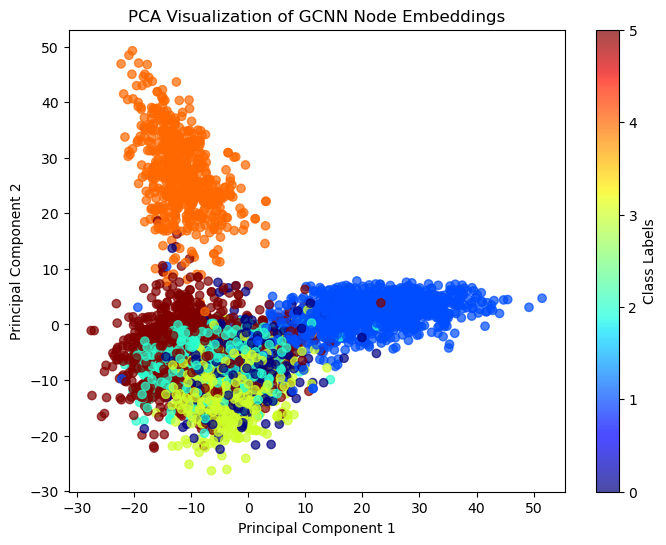

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Function to extract embeddings correctly (before final classification layer)
def extract_gcnn_embeddings(model, graph):
    model.eval()
    with torch.no_grad():
        x = model.conv1(graph.x.to(device), graph.edge_index.to(device))  # Pass edge weights
        x = model.norm1(x)  # Normalize
        x = F.relu(x)
        #x = model.dropout(x)

        x = model.conv2(x, graph.edge_index.to(device))  # Pass edge weights
        #x = model.norm2(x)
        #x = F.relu(x)
        #x = model.dropout(x)

    return x.cpu().numpy()  # Convert to NumPy

# Extract node embeddings from the test graph
test_graph_embeddings = extract_gcnn_embeddings(model, test_graph)
test_labels = test_graph.y.cpu().numpy()  # Get test labels

print(f"Extracted GCNN Embeddings Shape: {test_graph_embeddings.shape}")  # Expected: (num_nodes, hidden_channels)



#######USING PCA FOR VISUALIZATION#######


# Reduce embeddings to 2D using PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(test_graph_embeddings)

# Plot embeddings with colors based on class labels
plt.figure(figsize=(8,6))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=test_labels, cmap="jet", alpha=0.7)
plt.colorbar(scatter, label="Class Labels")
plt.title("PCA Visualization of GCNN Node Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

### PCA captures linear relationships, but t-SNE can capture nonlinear structures better.

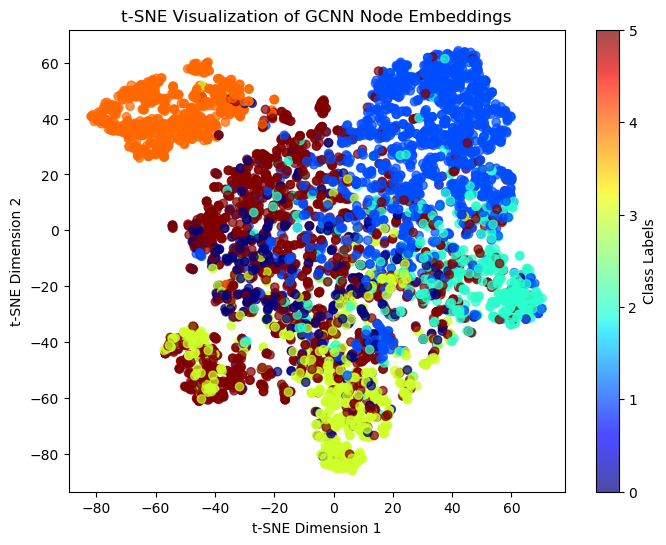

In [22]:
from sklearn.manifold import TSNE

# Reduce embeddings to 2D using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced_cnn_tsne = tsne.fit_transform(test_graph_embeddings)

# Plot CNN embeddings
plt.figure(figsize=(8,6))
scatter = plt.scatter(reduced_cnn_tsne[:, 0], reduced_cnn_tsne[:, 1], c=test_labels, cmap="jet", alpha=0.7)
plt.colorbar(scatter, label="Class Labels")
plt.title("t-SNE Visualization of GCNN Node Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

### Compute Test Accuracy and Confusion Matrix for GCNN Model

GCNN Test Accuracy: 2265/2411 (93.94%)


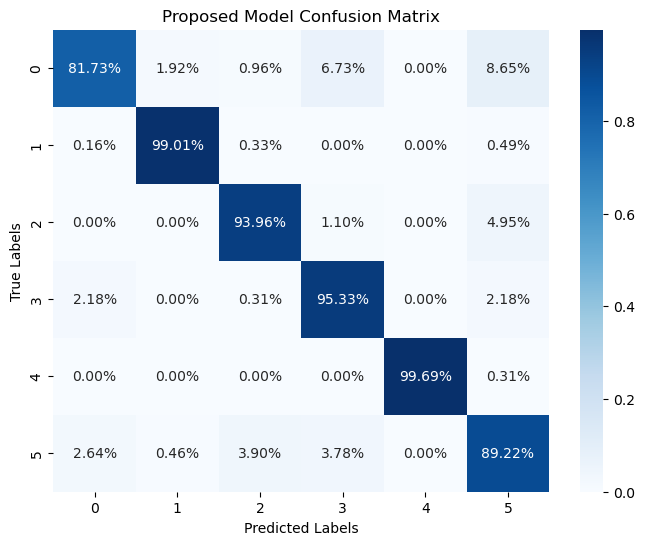

In [75]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

correct = (pred == test_graph.y.to(device)).cpu().numpy()
total = test_graph.y.size(0)
test_acc = (correct.sum() / total) * 100
print(f"GCNN Test Accuracy: {correct.sum()}/{total} ({test_acc:.2f}%)")

# Plot confusion matrix with percentages
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(test_graph.y, pred.cpu().numpy())
conf_matrix_pct = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_matrix_pct, annot=True, fmt='.2%', cmap='Blues', cbar=True)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Proposed Model Confusion Matrix")
plt.show()

